# Setup

In [1]:
import LLMSR
import openai
import sympy as sp
import pickle

import numpy as np
import matplotlib.pyplot as plt
import torch.nn

from kan import *

In [2]:
client = openai.OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)
LLMSR.llm.check_key_limit(client)

41.0487839

# First Function $e^{\sin{\pi x} + y^2}$

## Fit KAN

cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-03 | test_loss: 1.58e-03 | reg: 1.42e+01 | : 100%|█| 500/500 [00:43<00:00, 11.52


saving model version 0.1


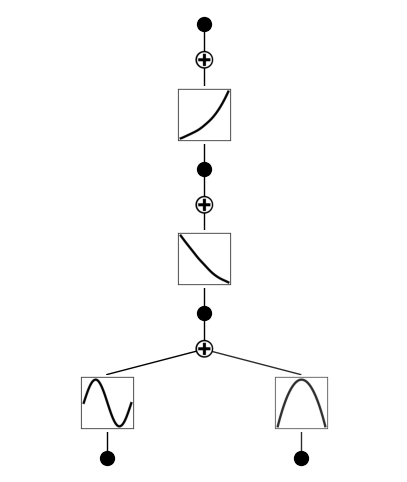

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# initialize KAN with G=3
model = KAN(width=[2,1,1,1], grid=7, k=3, seed=0, device=device, symbolic_enabled=False)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, train_num=10000, test_num=1000, device=device)
res = model.fit(dataset, opt="LBFGS", steps=500);
model.plot()

## Fit Splines

(0, 0, 0)


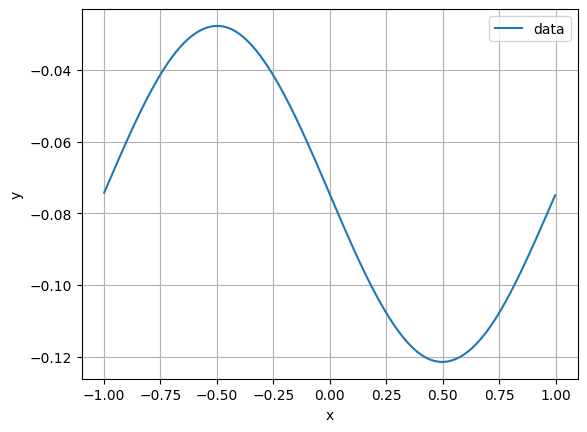

Checking constant function
Constant function is not a good fit.
Score:  -0.1991643867800007
Constant:  [-0.07408782]
Generating Initial population population


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


Best score:  -0.14065519025508733
Best ansatz:  params[0] + params[1] * x
Best params:  [-0.07480579 -0.0444165 ]
Generation: 1


100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


Best score:  -5.391468799177339e-07
Best ansatz:   params[0] * np.sin(params[1] * x + params[2]) + params[3]
Best params:  [ 0.04691995  3.14150789  3.14154378 -0.07456407]
Exit condition met.
(0, 1, 0)


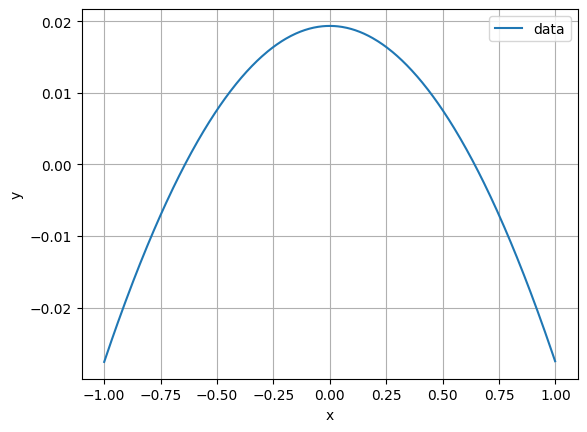

Checking constant function
Constant function is not a good fit.
Score:  -17.051461557053848
Constant:  [0.00328124]
Generating Initial population population


100%|██████████| 10/10 [00:57<00:00,  5.80s/it]

Best score:  -1.8419313230590596e-07
Best ansatz:   params[0] + params[1] * x + params[2] * x**2
Best params:  [ 1.93246382e-02  7.39445429e-08 -4.69220818e-02]
Exit condition met.
(1, 0, 0)


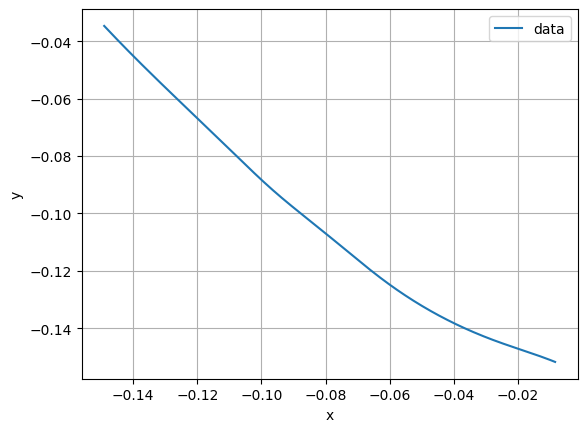

Checking constant function
Constant function is not a good fit.
Score:  -0.0715603568818804
Constant:  [-0.1110468]
Generating Initial population population


100%|██████████| 10/10 [00:32<00:00,  3.24s/it]


Best score:  -0.0022652464147625826
Best ansatz:   params[0] * x + params[1]
Best params:  [-0.81843279 -0.16899723]
Generation: 1


100%|██████████| 10/10 [00:29<00:00,  2.98s/it]

Best score:  -0.00016551339595507848
Best ansatz:   params[0] + params[1] * x + params[2] * x**2
Best params:  [-0.15576285 -0.32432888  3.45090697]
Exit condition met.
(2, 0, 0)


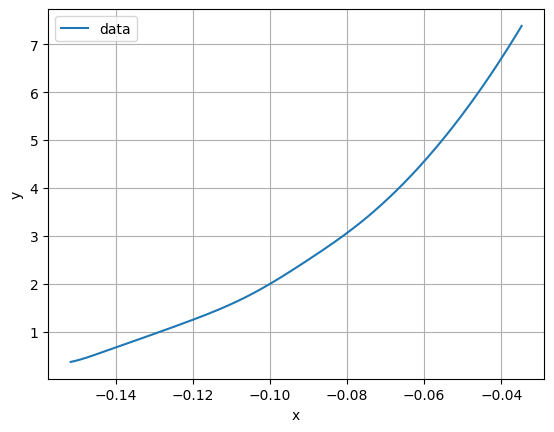

Checking constant function
Constant function is not a good fit.
Score:  -0.5716165298782193
Constant:  [1.84716472]
Generating Initial population population


100%|██████████| 10/10 [00:37<00:00,  3.72s/it]


Best score:  -0.005801959798783678
Best ansatz:   params[0] + params[1] * x + params[2] * x**2
Best params:  [ 10.79894681 126.69240961 387.24401604]
Generation: 1


 20%|██        | 2/10 [00:07<00:29,  3.72s/it]

Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Getting another response from LLM


 70%|███████   | 7/10 [00:22<00:09,  3.23s/it]

Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Getting another response from LLM


100%|██████████| 10/10 [00:31<00:00,  3.13s/it]

Best score:  -7.252452795296295e-05
Best ansatz:   params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3
Best params:  [  13.24946467  210.91563101 1283.20778229 2988.45239609]
Exit condition met.


In [4]:
sym_expr = LLMSR.kan_to_symbolic(model, client, gpt_model="openai/gpt-4o", exit_condition=min(res['train_loss']).item())

In [5]:
with open('./sym_expr_4o_func1.pkl', 'wb') as hnd:
    pickle.dump(sym_expr, hnd)

## Reconstructing Function

In [6]:
with open('./sym_expr_4o_func1.pkl', 'rb') as hnd:
    sym_expr = pickle.load(hnd)

In [7]:
initial_params = []
for kan_conn, sub_res in sym_expr[0].items():
    if sub_res is None:
        print(f"Could not fit a function for connection {kan_conn}")
        continue
    highest_score_element = max((item for sublist in sub_res for item in sublist), key=lambda item: item['score'])
    print(f"Approximation for {kan_conn}: {highest_score_element['ansatz'].strip()}")
    print(f"Parameters are {np.round(highest_score_element['params'], 3)}")
    initial_params += list(highest_score_element['params'])

Approximation for (0, 0, 0): params[0] * np.sin(params[1] * x + params[2]) + params[3]
Parameters are [ 0.047  3.142  3.142 -0.075]
Approximation for (0, 1, 0): params[0] + params[1] * x + params[2] * x**2
Parameters are [ 0.019  0.    -0.047]
Approximation for (1, 0, 0): params[0] + params[1] * x + params[2] * x**2
Parameters are [-0.156 -0.324  3.451]
Approximation for (2, 0, 0): params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3
Parameters are [  13.249  210.916 1283.208 2988.452]


In [8]:
def learned_f(X, *params):
    x0, x1 = X
    l11 = params[0] * np.sin(params[1] * x0) + params[2]
    l12 = params[4] * params[4]*x1**2 + params[5]
    sumL1 = l11 + l12
    l21 = params[6] + params[7] * sumL1 + params[8] * sumL1**2
    l31 = params[9] + params[10] * l21 + params[11] * sumL1**2 + params[12] * sumL1**3
    return l31

In [9]:
from scipy.optimize import curve_fit
initial_params = np.random.uniform(-1, 1, 15)
popt, _ = curve_fit(learned_f, (dataset['train_input'].cpu().detach().numpy()[:,0], dataset['train_input'].cpu().detach().numpy()[:,1]), dataset['train_label'].cpu().detach().numpy().flatten(), p0=initial_params, maxfev=100000)
popt

/var/folders/b6/m5qrk7z12lxb7lpygv99mnmw0000gn/T/ipykernel_30778/220709232.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(learned_f, (dataset['train_input'].cpu().detach().numpy()[:,0], dataset['train_input'].cpu().detach().numpy()[:,1]), dataset['train_label'].cpu().detach().numpy().flatten(), p0=initial_params, maxfev=100000)


array([ 0.44805687,  3.14188131, -0.26144631,  0.14455771, -0.67199979,
        0.47695221, -1.22307358, -1.37972478, -0.75612437, -0.58364853,
       -1.00069265, -0.18685902,  3.11226636,  0.59775535,  0.622503  ])

# Second Function $\frac{M m}{r^2}$

# Third Function $\frac{u+v}{1+uv}$